In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding

import seaborn as sns
sns.set(style = 'whitegrid')

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('../Clean_Dataset.csv', encoding='UTF-8')

In [3]:
train = df[['Clean_Text','Stop_Words_Text', 'Stemmed_Text', 'indonlp_sentiment', 'Lexicon_Score']]

In [4]:
len(df['Clean_Text'])

41222

#### Data Preprocessing

In [5]:
data = df['Clean_Text'].values.tolist()

In [6]:
print(data[:5])

['cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua negara berlomba lomba membangun dunia virtual atau metaverse', 'katanya mau metaverse tapi down melulu bagaimana mas zuck', 'mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai stable currency mereka kalau memang pasti nanti pindah ke blokchain semua facebook masih menang banyak karena hanya memerlukan pembaruan teknologi penggunanya sudah banyak', 'bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus bersatu untuk membentuk ekosistem metaverse yang melibatkan teknologi ar vr dan xr dalam forum tersebut juga dibahas bagaimana mensukseskan platform ini dengan pasar konsumen', 'sama sama semoga selalu terhindar dari usaha tipu menipu di metaverse iya']


### Building a Model

#### Label Encoding of Output

In [7]:
import tensorflow as tf
labels = np.array(train['indonlp_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

#### Tokenizing dan Padding Padding

In [8]:
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
X = pad_sequences(sequences, maxlen=max_len)
print(X)

[[    0     0     0 ...    29    43     1]
 [    0     0     0 ...    57   218  1485]
 [    0     0     0 ...  1555    10    45]
 ...
 [    0     0     0 ...  1002     5   438]
 [    0     0     0 ...  1914   751 14967]
 [    0     0     0 ...   195     2   630]]


In [9]:
scaler = MinMaxScaler()

In [10]:
# extract sentiment scores
sentiment_scores = df['Lexicon_Score'].values

# perform min-max scaling on sentiment scores
scaler = MinMaxScaler()
sentiment_scaled = scaler.fit_transform(sentiment_scores.reshape(-1, 1))

df['Sentiment_Scaled'] = sentiment_scaled 

In [11]:
df['Sentiment_Scaled']

0        0.601504
1        0.518797
2        0.744361
3        0.593985
4        0.518797
           ...   
41217    0.533835
41218    0.541353
41219    0.458647
41220    0.473684
41221    0.548872
Name: Sentiment_Scaled, Length: 41222, dtype: float64

In [12]:
#Combine sentiment scores with text data
X = np.hstack((sentiment_scaled, X))
y = labels

In [13]:
print(X.shape)

(41222, 101)


In [14]:
X = X[:, :-1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32977, 100) (32977, 3)
(8245, 100) (8245, 3)


#### LSTM

In [16]:
embedding_layer = Embedding(1000, 64)

In [37]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.8)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train Model

In [38]:
history = model2.fit(X,y, epochs=10,validation_split=0.2)

Epoch 1/10
1031/1031 [==============================] - 70s 61ms/step - loss: 0.7369 - accuracy: 0.6773 - val_loss: 0.5894 - val_accuracy: 0.7653
Epoch 2/10
1031/1031 [==============================] - 61s 59ms/step - loss: 0.5741 - accuracy: 0.7627 - val_loss: 0.5335 - val_accuracy: 0.7936
Epoch 3/10
1031/1031 [==============================] - 63s 62ms/step - loss: 0.5083 - accuracy: 0.7928 - val_loss: 0.5419 - val_accuracy: 0.7962
Epoch 4/10
1031/1031 [==============================] - 60s 58ms/step - loss: 0.4619 - accuracy: 0.8126 - val_loss: 0.5348 - val_accuracy: 0.7956
Epoch 5/10
1031/1031 [==============================] - 59s 58ms/step - loss: 0.4293 - accuracy: 0.8258 - val_loss: 0.5369 - val_accuracy: 0.7996
Epoch 6/10
1031/1031 [==============================] - 60s 58ms/step - loss: 0.3978 - accuracy: 0.8402 - val_loss: 0.5593 - val_accuracy: 0.7973
Epoch 7/10
1031/1031 [==============================] - 60s 58ms/step - loss: 0.3784 - accuracy: 0.8487 - val_loss: 0.5985 -

258/258 [==============================] - 4s 9ms/step
Model Accuracy on Test Data: 0.8906003638568829


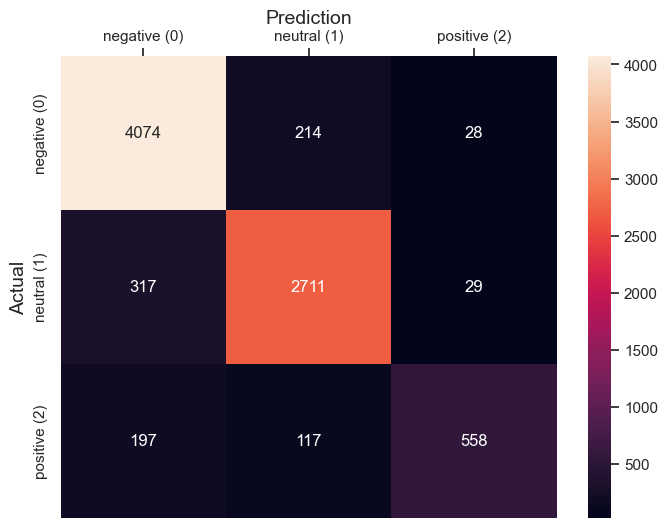

In [39]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [40]:
# predict classes for test set
y_pred = np.argmax(model2.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


258/258 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4316
           1       0.89      0.89      0.89      3057
           2       0.91      0.64      0.75       872

    accuracy                           0.89      8245
   macro avg       0.90      0.82      0.85      8245
weighted avg       0.89      0.89      0.89      8245

[[4074  214   28]
 [ 317 2711   29]
 [ 197  117  558]]


In [41]:
# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_int, y_pred)
precision = precision_score(y_test_int, y_pred, average='macro')
recall = recall_score(y_test_int, y_pred, average='macro')
f1 = f1_score(y_test_int, y_pred, average='macro')

In [42]:
# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))

Accuracy: 89.06%
Precision: 89.55%
Recall: 82.36%
F1-score: 85.15%


#### Prediksi dan Hasil

In [21]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [22]:
sequence = tokenizer.texts_to_sequences(['metaverse teknologi yang sangat buruk'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Negative'

In [23]:
sequence = tokenizer.texts_to_sequences(['wow metaverse teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 30ms/step


'Positive'

In [24]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi tersebut'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 31ms/step


'Neutral'

#### Model dengan beberapa penyesuaian (Fine-Tuning)

In [25]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.5)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history2 = model.fit(X,y, epochs=20,validation_split=0.2)

Epoch 1/20
1031/1031 [==============================] - 52s 50ms/step - loss: 0.4365 - accuracy: 0.8308 - val_loss: 0.3942 - val_accuracy: 0.8628
Epoch 2/20
1031/1031 [==============================] - 52s 50ms/step - loss: 0.4260 - accuracy: 0.8354 - val_loss: 0.4023 - val_accuracy: 0.8602
Epoch 3/20
1031/1031 [==============================] - 50s 49ms/step - loss: 0.3992 - accuracy: 0.8460 - val_loss: 0.4238 - val_accuracy: 0.8541
Epoch 4/20
1031/1031 [==============================] - 52s 51ms/step - loss: 0.3797 - accuracy: 0.8556 - val_loss: 0.4505 - val_accuracy: 0.8449
Epoch 5/20
1031/1031 [==============================] - 67s 65ms/step - loss: 0.3715 - accuracy: 0.8570 - val_loss: 0.4716 - val_accuracy: 0.8418
Epoch 6/20
1031/1031 [==============================] - 67s 65ms/step - loss: 0.3645 - accuracy: 0.8603 - val_loss: 0.4368 - val_accuracy: 0.8466
Epoch 7/20
1031/1031 [==============================] - 70s 68ms/step - loss: 0.3542 - accuracy: 0.8653 - val_loss: 0.4413 -

258/258 [==============================] - 2s 9ms/step
Model Accuracy on Test Data: 0.9191024863553668


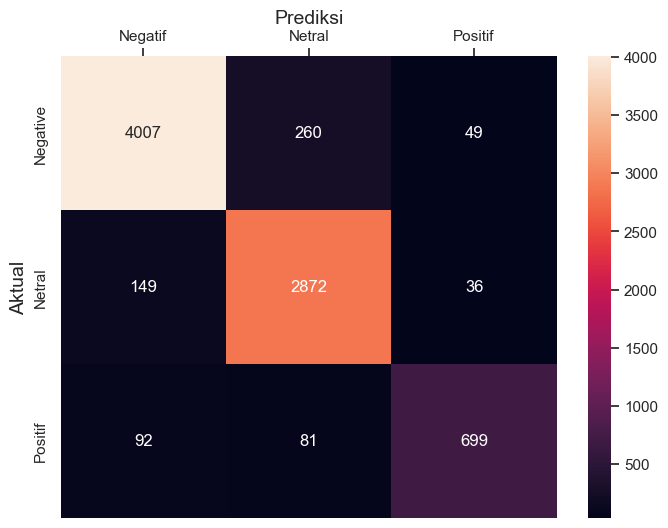

In [27]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediksi', fontsize=14)
ax.set_xticklabels(['Negatif', 'Netral', 'Positif'])
ax.set_ylabel('Aktual', fontsize=14)
ax.set_yticklabels(['Negative', 'Netral', 'Positif'])
plt.show()


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


258/258 [==============================] - 3s 13ms/step
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4316
           1       0.88      0.87      0.87      3057
           2       0.87      0.61      0.72       872

    accuracy                           0.88      8245
   macro avg       0.87      0.81      0.83      8245
weighted avg       0.88      0.88      0.87      8245

[[4024  250   42]
 [ 355 2664   38]
 [ 218  121  533]]


In [29]:
sequence = tokenizer.texts_to_sequences(['pada sadar tidak yang namanya metaverse kok kyknya bakal jadi satu kegilan baru era digital'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 46ms/step


'Neutral'

In [30]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi metaverse kedepannya'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 35ms/step


'Neutral'

In [31]:
sequence = tokenizer.texts_to_sequences(['teknologi yang sangat menjanjikan, semoga dapat diterapkan secara masif'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 34ms/step


'Positive'